## This notebook has functions to trim/fade samples, then to plot them as waveforms(time), spectrums, and spectrograms. The batch processing section handles multiple files, plot types, and folders.
---------------------------------------------------------------

### Imports



In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import os


### Utility Function Definitions



In [3]:
def trim(y, sr, start_seconds, end_seconds):
    # Convert start and end times to samples
    start_sample = int(start_seconds * sr)
    end_sample = int(end_seconds * sr)
    
    # Trim the audio
    y = y[start_sample:end_sample]
    
    return y         

In [4]:
def apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS):
    """
    Apply Hann window to the audio signal
    
    Parameters:
    - y: numpy array of audio samples
    - sr: the samplerate
    - FADE_DURATION_SECONDS: length of the window to apply in s
    
    Returns:
    - windowed audio signal
    """
    
    window_samples = int(FADE_DURATION_SECONDS * sr)


    # Create Hann window
    hann_window = np.hanning(window_samples * 2)
    
    # Split window into fade-in and fade-out
    fade_in = hann_window[:window_samples]
    fade_out = hann_window[window_samples:]
    
    # Apply fade-in to the beginning
    y[:window_samples] *= fade_in
    
    # Apply fade-out to the end
    y[-window_samples:] *= fade_out
    
    return y

### Plotting Function Definitions



In [5]:
def plot_spectogram(y, sr, fig, ax, n_fft=2048, hop_length=512, title=None):
    """
    Plot a log-frequency power spectrogram of an audio signal.
    
    Parameters:
        y (np.ndarray): Input audio signal
        sr (int): Sampling rate of the audio
        hop_length (int, optional): Number of samples between successive STFT columns. Default: 1024
        figsize (tuple, optional): Figure size (width, height). Default: (12, 8)
    
    Returns:
        tuple: Figure and axis objects (fig, ax)
    """
    # Compute spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)),
                               ref=np.max)
    

    # Display spectrogram
    img = librosa.display.specshow(D, 
                                 y_axis='log',
                                 x_axis='time',
                                 hop_length=hop_length,
                                 sr=sr,
                                 ax=ax)
    
    # remove minor y axis ticks
    ax.tick_params(axis='y', which='minor', left=False)
    
    if (20000 < (sr/2)):
        ax.set_ylim(20, 20000)
        ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000])
    else:
        ax.set_ylim(20, sr/2)
        ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 7000, sr/2])

    
    # Set title and add colorbar
    if title:
        ax.set_title(title, pad=15)    
    else:
        ax.set_title('Log-frequency power spectrogram', pad=15)    

    fig.colorbar(img, ax=ax, format="%+2.f dB")
    


In [6]:
def plot_spectrum(y, sr, fig, ax, title=None):
    """Plot magnitude spectrum with frequency axis in Hz."""
    
    # Perform FFT and calculate magnitude
    ft = np.fft.rfft(y)  # Already gives just the positive frequencies
    freqs = np.fft.rfftfreq(len(y), 1/sr)  # Frequencies for rfft
    magnitude_spectrum = np.abs(ft)  # No need to slice
    
    # Convert magnitude to decibels
    magnitude_db = librosa.amplitude_to_db(magnitude_spectrum, ref=np.max)
    
    # Plot the spectrum
    img = ax.plot(freqs, magnitude_db)
    
    # Set log scale and ticks
    ax.set_xscale('log')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.grid(True, which='major', linestyle='-', alpha=0.3)

    if (20000 < (sr/2)):
        ax.set_xlim(20, 20000)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)    
    else:
        ax.set_xlim(20, sr/2)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 5000, sr/2]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks) 

    
    ax.set_ylim(-80, 0)  

    
    # Labels
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude (dB)')
    if title:
        ax.set_title(title, pad=15) 
    else:
        ax.set_title('Spectrum', pad=15) 



In [7]:
def plot_time(y, sr, fig, ax, title=None):
    """Plot time-domain signal with improved visualization."""
    # Create time axis in seconds
    times = np.arange(len(y)) / sr
    
    # Plot the waveform
    ax.plot(times, y, color='#1f77b4', linewidth=0.75)  # Thinner line for better detail
    
    # Set title and labels 
    if title:
        ax.set_title(title, pad=15)    
    else:
        ax.set_title('Waveform', pad=15)    
        
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    
    # Add grid for better readability
    ax.grid(True, alpha=0.2)
    
    # Set y-axis limits symmetrically based on the signal
    max_amp = np.max(np.abs(y))
    ax.set_ylim(-max_amp, max_amp)
    ax.set_xlim(0, times[-1])

    

### Single file run (with example.wav)




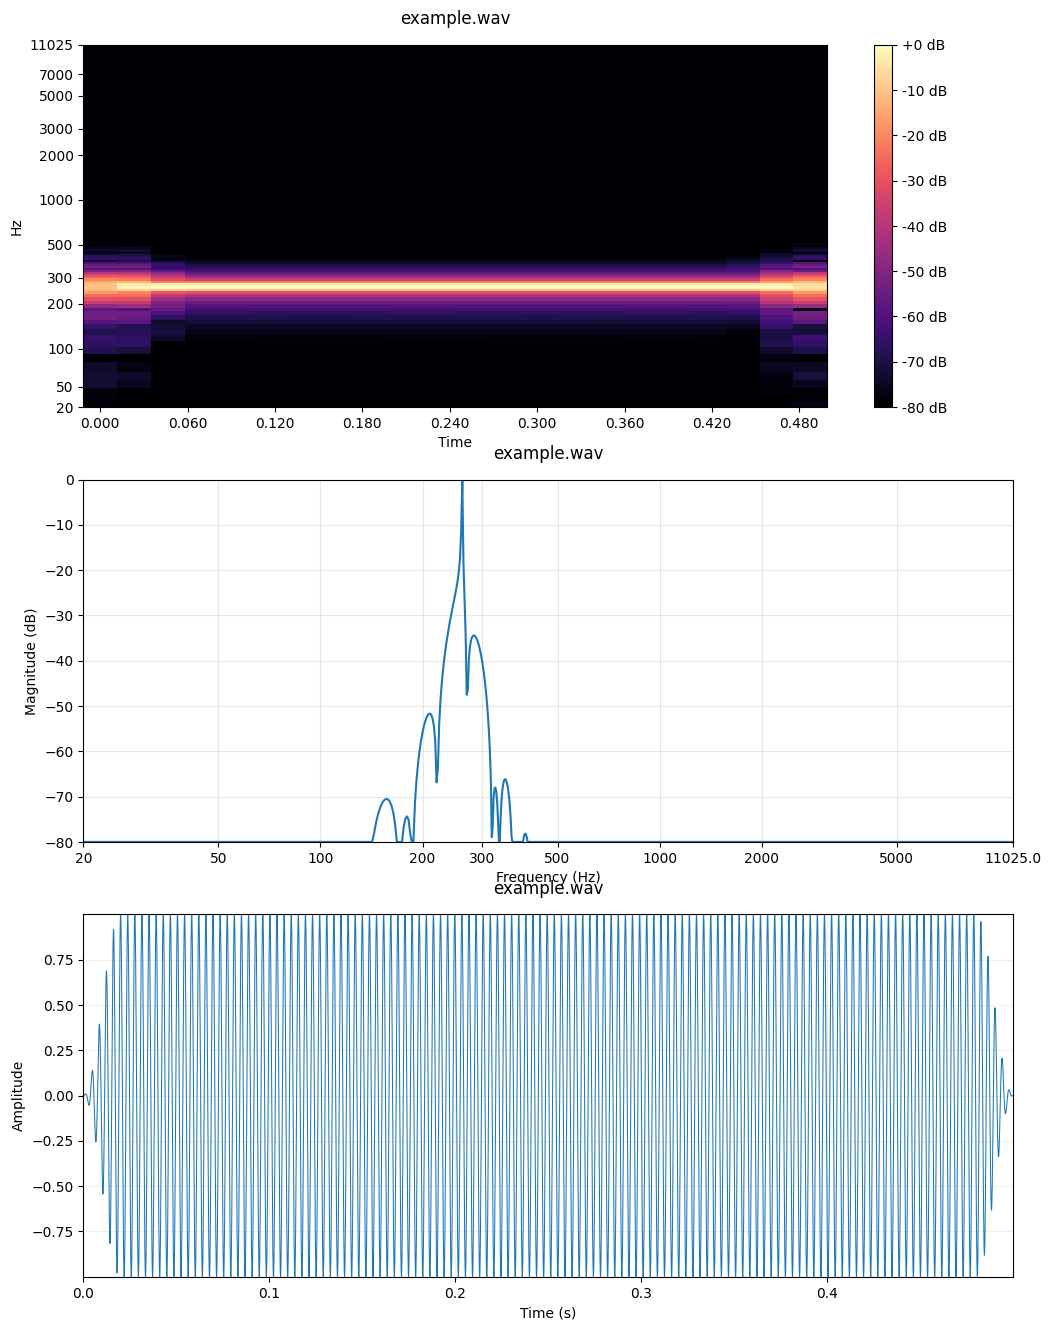

In [9]:
file = './example.wav'
y, sr = librosa.load(file,sr=22050)
title = os.path.basename(file) 

y = trim(y, sr, 0, 0.5)
y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS=0.02) #20ms fades
# Create fig and ax objects
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))

plot_spectogram(y, sr, fig, ax1, n_fft=2048, hop_length=512, title=title)
plot_spectrum(y, sr, fig, ax2, title=title)
plot_time(y, sr, fig, ax3, title=title)

plt.show()
# Audio(y, rate=sr)

### Batch processing




##### PDF page for each file with all three plots

In [18]:
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

INPUT_FOLDER = './samples/singlenotes_nofades/york/aom5024/'
OUTPUT_PATH = './PDFs/york/york_notes_aom5024.pdf'
TRIM_SECONDS = 0.5
FADE_DURATION_SECONDS = 0.02 #20ms fade

# Create output directory if it doesn't exist
output_dir = str(Path(OUTPUT_PATH).parent)  # Gets the directory part of the output path
Path(output_dir).mkdir(parents=True, exist_ok=True)

with PdfPages(OUTPUT_PATH) as pdf:
    # Process all wav files in folder alphabetically
    wav_files = sorted(Path(INPUT_FOLDER).glob('*.wav'))
    for file in wav_files:
        # Load audio
        y, sr = librosa.load(str(file), sr=22050)
        title = os.path.basename(file)
        y = trim(y, sr, 0, TRIM_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS=FADE_DURATION_SECONDS)
        
        # Create a figure with three subplots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))
        
        # Create plots in subplots
        plot_spectogram(y, sr, fig, ax1, n_fft=2048, hop_length=512, title=title)
        plot_spectrum(y, sr, fig, ax2, title=title)
        plot_time(y, sr, fig, ax3, title=title)
        
        plt.tight_layout()
        
        # Save the page
        pdf.savefig(fig)
        
        # Close the figure to free memory
        plt.close(fig)

##### PDF with all notes on same plot type

In [21]:
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

# Configuration
PLOT_TYPE = 'SPECTROGRAM'  # SPECTROGRAM/SPECTRUM/TIME
INPUT_FOLDER = './samples/singlenotes_nofades/york/aom5024/'
OUTPUT_PATH = f'./PDFs/York/{PLOT_TYPE}_aom5024.pdf'  # Made lowercase to keep filenames clean
FIGSIZE = (12, 8)
ROWS = 2
COLUMNS = 2
PLOTS_PER_PAGE = ROWS * COLUMNS

# Create output directory if it doesn't exist
output_dir = str(Path(OUTPUT_PATH).parent)  # Gets the directory part of the output path
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Create figure with subplots and start PDF
fig, axes = plt.subplots(ROWS, COLUMNS, figsize=FIGSIZE)
axes = axes.flatten()
plot_count = 0

# Add spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust these values as needed

with PdfPages(OUTPUT_PATH) as pdf:
    # Process each wav file alphabetically
    for file in sorted(Path(INPUT_FOLDER).glob('*.wav')):
        # Load audio
        y, sr = librosa.load(str(file), sr=22050)
        y = trim(y, sr, 0, TRIM_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS=FADE_DURATION_SECONDS)
        title = os.path.basename(file)
        
        # Make plot based on type
        if PLOT_TYPE == 'SPECTROGRAM':
            plot_spectogram(y, sr, fig, axes[plot_count], title=title)
        elif PLOT_TYPE == 'SPECTRUM':
            plot_spectrum(y, sr, fig, axes[plot_count], title=title)
        elif PLOT_TYPE == 'TIME':
            plot_time(y, sr, fig, axes[plot_count], title=title)
        
        plot_count += 1
        
        # When page is full, save it and start new page
        if plot_count == PLOTS_PER_PAGE:
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)
            fig, axes = plt.subplots(ROWS, COLUMNS, figsize=FIGSIZE)
            axes = axes.flatten()
            plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Also for new pages
            plot_count = 0
    
    # Save the last page if there are any plots
    if plot_count > 0:
        # Hide empty subplots
        for i in range(plot_count, PLOTS_PER_PAGE):
            axes[i].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDFs for each note - sample plot type - ACROSS two different folders

In [30]:
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

# Configuration
PLOT_TYPE = 'TIME'  # SPECTROGRAM/SPECTRUM/TIME
INPUT_FOLDER1 = './samples/singlenotes_nofades/york/aom5024/'
INPUT_FOLDER2 = './samples/singlenotes_nofades/yamaha/aom5024/'
OUTPUT_PATH = f'./PDFs/Comparison/{PLOT_TYPE}_aom5024.pdf'
FIGSIZE = (12, 8)
ROWS = 2
COLUMNS = 1
PLOTS_PER_PAGE = ROWS * COLUMNS

# Create output directory if it doesn't exist
output_dir = str(Path(OUTPUT_PATH).parent)
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Get sorted lists of files from both folders
files1 = sorted(list(Path(INPUT_FOLDER1).glob('*.wav')))
files2 = sorted(list(Path(INPUT_FOLDER2).glob('*.wav')))

# Find max length to know how many pairs we need to process
max_files = max(len(files1), len(files2))

with PdfPages(OUTPUT_PATH) as pdf:
    for i in range(0, max_files):  # Process one file at a time
        # Create new figure for each pair
        fig, axes = plt.subplots(ROWS, COLUMNS, figsize=FIGSIZE)
        if ROWS == 1:
            axes = [axes]  # Make it indexable if only one row
        plt.subplots_adjust(hspace=0.4)
        
        # Plot file from folder 1 if available
        if i < len(files1):
            y1, sr1 = librosa.load(str(files1[i]), sr=22050)
            y1 = trim(y1, sr1, 0, TRIM_SECONDS)
            y1 = apply_hann_window_fades(y1, sr1, FADE_DURATION_SECONDS=FADE_DURATION_SECONDS)
            if PLOT_TYPE == 'SPECTROGRAM':
                plot_spectogram(y1, sr1, fig, axes[0], title=f"York: {files1[i].name}")
            elif PLOT_TYPE == 'SPECTRUM':
                plot_spectrum(y1, sr1, fig, axes[0], title=f"York: {files1[i].name}")
            elif PLOT_TYPE == 'TIME':
                plot_time(y1, sr1, fig, axes[0], title=f"York: {files1[i].name}")
        else:
            axes[0].text(0.5, 0.5, 'No more files in York folder', ha='center', va='center')
            axes[0].set_title("York (empty)")
        
        # Plot file from folder 2 if available
        if i < len(files2):
            y2, sr2 = librosa.load(str(files2[i]), sr=22050)
            y2 = trim(y2, sr2, 0, TRIM_SECONDS)
            y2 = apply_hann_window_fades(y2, sr2, FADE_DURATION_SECONDS=FADE_DURATION_SECONDS)
            if PLOT_TYPE == 'SPECTROGRAM':
                plot_spectogram(y2, sr2, fig, axes[1], title=f"Yamaha: {files2[i].name}")
            elif PLOT_TYPE == 'SPECTRUM':
                plot_spectrum(y2, sr2, fig, axes[1], title=f"Yamaha: {files2[i].name}")
            elif PLOT_TYPE == 'TIME':
                plot_time(y2, sr2, fig, axes[1], title=f"Yamaha: {files2[i].name}")
        else:
            axes[1].text(0.5, 0.5, 'No more files in Yamaha folder', ha='center', va='center')
            axes[1].set_title("Yamaha (empty)")
        
        # Save current page
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)